<a href="https://colab.research.google.com/github/sharvaree1921/ITS21013/blob/main/itsp_project_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-plot
!pip install spotipy

import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

import os
import sys
import json
import spotipy
import webbrowser
import spotipy.util as util
from json.decoder import JSONDecodeError
from spotipy.oauth2 import SpotifyClientCredentials


     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 143kB 22.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.26.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/ITSP/Dataset_for_ITSP/fer2013.csv')
print(df.shape)
df.head()

Mounted at /content/gdrive
(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df.emotion.value_counts()


3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
INTERESTED_LABELS = [0, 2, 3, 4, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(31338, 3)

In [ ]:
# Making the data compatible for neural networks
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape

(31338, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(31338, 5)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 6: 4}


In [ ]:
# Splitting the data into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28204, 48, 48, 1), (3134, 48, 48, 1), (28204, 5), (3134, 5))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ITSP/trial7.h5')

# Show the model architecture
new_model.summary()

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batchnorm_3 (BatchNormalizat (None, 24, 24, 128)       512    

In [ ]:
mapper = {
    0: "anger",
    1: "fear",
    2: "happy",
    3: "sad",
    4: "neutral"
}


In [ ]:
os.environ['SPOTIPY_CLIENT_ID']='d1a408a2e9b445c3a93fc530703f0734'
os.environ['SPOTIPY_CLIENT_SECRET']='f4a5ad5b759f4821ad1edbf13eb1ca80'
os.environ['SPOTIPY_REDIRECT_URI']='https://example.com/'

In [ ]:
# In order to access the spotify account
auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
# From here, the next 2 blocks contain code for taking an image through the camera
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
from PIL import Image 
import PIL 

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


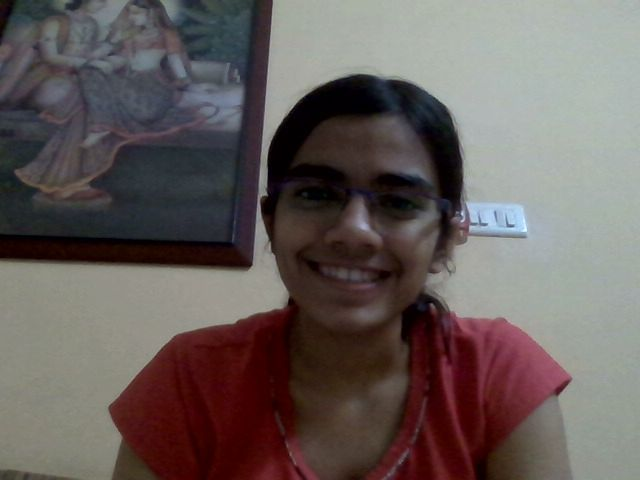

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# Read the input image
from PIL import Image
import PIL
img = cv2.imread('photo.jpg')
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load the cascade
face_cascade = cv2.CascadeClassifier('/content/gdrive/MyDrive/ITSP/haarcascade_frontalface_alt2.xml')
 
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces:
  cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 0, 255), 2)
  faces = gray[y:y + h, x:x + w]
  faces =  cv2.resize(faces, (48,48))
  faces = faces.flatten()
  text = ""
  for i in faces:
    text = (text+"%d"+"") % i
  text = text[:-1]

img_array = np.array(faces).reshape(48,48,1).astype('float32')
img_array = np.stack(img_array,axis=0)
img_array = img_array/255
img_array = np.expand_dims(img_array,axis=0)



In [ ]:
x = new_model.predict(img_array)      # x is an array
y = np.argmax(x)

accuracy = "{:.2f}".format(x.max()/np.sum(x)*100)
print('By ' + accuracy + ' % accuracy, your emotion is ' + mapper[y] + '.')
print('Here is a list of songs recommended for you: \n')

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())
anger  = 'https://open.spotify.com/playlist/1rqIpiQrUnLwAPthCPzMnK'
fear   = 'https://open.spotify.com/playlist/6ObXEIth1FXUxcJT0twvFL'
happy  = 'https://open.spotify.com/playlist/41oHHmGGVJNXhMGNrc1HzM'
sad    = 'https://open.spotify.com/playlist/1ETCQnUmh7Bm3JKi1riTKc'
neutral= 'https://open.spotify.com/playlist/4Oj7vgriJHRkMMYRtYvaFy'

url_array = [anger, fear, happy, sad, neutral]
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())
result  = []
for m in range(5):
  result.append(spotify.playlist_items(url_array[m]))

for item in result[y]['items']:
  print('song       : ' + item['track']['name'])
  print('Click here : ' + str(item['track']['external_urls']))
  print('Artist(s)  : ' + item['track']['artists'][0]['name'])
  print('\n')


By 97.29 % accuracy, your emotion is happy.
Here is a list of songs recommended for you: 

song       : Hey Jude
Click here : {'spotify': 'https://open.spotify.com/track/1eT2CjXwFXNx6oY5ydvzKU'}
Artist(s)  : The Beatles


song       : Dil Dhadakne Do
Click here : {'spotify': 'https://open.spotify.com/track/46elU7IBKWf55D5sjHGqO7'}
Artist(s)  : Joi Barua


song       : Here Comes The Sun - Remastered 2009
Click here : {'spotify': 'https://open.spotify.com/track/6dGnYIeXmHdcikdzNNDMm2'}
Artist(s)  : The Beatles


song       : (Everything I Do) I Do It For You
Click here : {'spotify': 'https://open.spotify.com/track/1Eb90nmqTrxylKFhcUzW8P'}
Artist(s)  : Bryan Adams


song       : Let It Be - Remastered 2009
Click here : {'spotify': 'https://open.spotify.com/track/7iN1s7xHE4ifF5povM6A48'}
Artist(s)  : The Beatles


song       : Memories
Click here : {'spotify': 'https://open.spotify.com/track/2b8fOow8UzyDFAE27YhOZM'}
Artist(s)  : Maroon 5


song       : The Most Beautiful Thing
Click here 